# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                ord=None,
                                time_samp_prop=0.2,
                                filter_row_idx=None,                                
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# 85 Channels - P41, Faces, Session 1

### Perform NMF for P41 - 85 Channels, Faces, Session 1 - DENORMALIZED TRIALS, IS DIVERGENCE NMF
#### (100% sampling of trials, 100% sampling of time)

In [2]:
np.random.seed(seed=103224)

In [3]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
ord = None # No normalization trials
samp_trial_pop = 1.0 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

# Get all trials for by channel

In [4]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)

# Run NMF - P41, Session 1, Ch10, Faces - Run all trials, up to 100Hz

In [5]:
V, W, H = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, 
                                      solver=solver,
                                      max_iter=max_iter)

84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!


99960


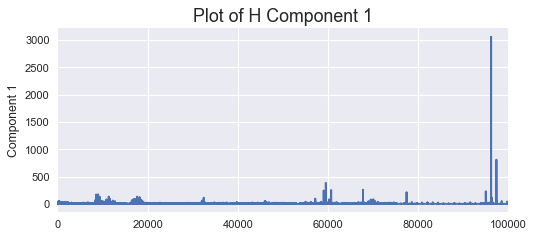

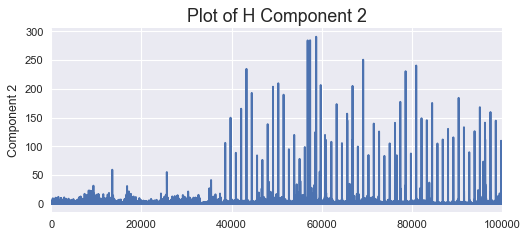

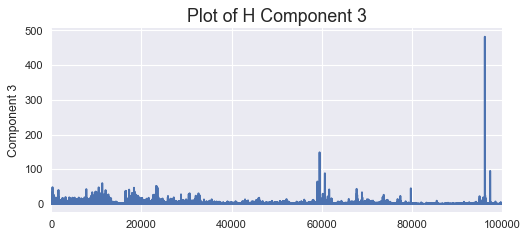

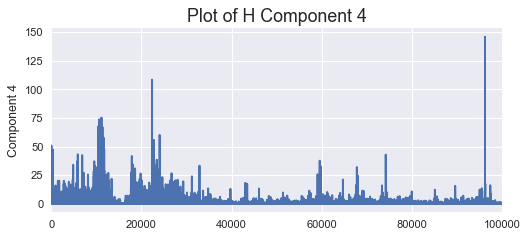

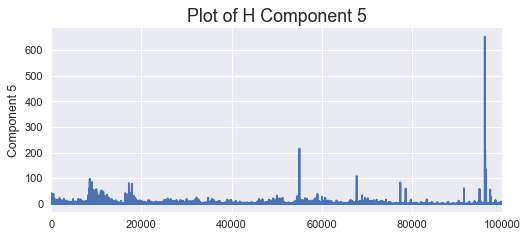

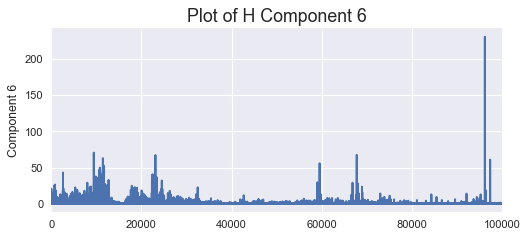

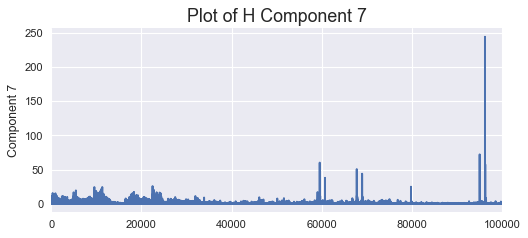

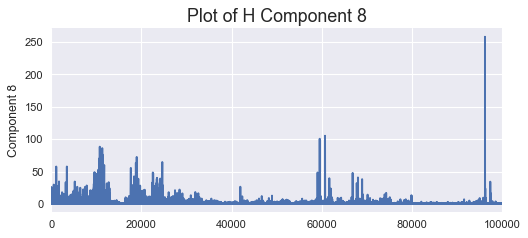

In [6]:
# Fit the spectrogram for a single trial
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[0][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)

freq_ticks = f[filter_row_idx]
#freq_ticks

# W-components
#plotW(W = W, log=False, x_ticks_l=freq_ticks)

# H-components
plotH(H = H, log=False, y_ticks_l=None)

## Get top MIN-k/ MAX-k values from array

In [10]:
def get_topk_vals_and_idx_byrow(a, k, max):
    
    if max:
        # TOP-k values
        # Find sorted indices for each row
        sorted_row_idx = np.argsort(a, axis=1)[:,a.shape[1]-k::]
    else:
        # BOTTOM-k values
        # Find sorted indices for each row
        sorted_row_idx = np.argsort(a, axis=1)[:, 0:k]        

    # Setup column indexing array
    col_idx = np.arange(a.shape[0])[:, None]

    # Use the column-row indices to get specific elements from input array. 
    # Please note that since the column indexing array isn't of the same shape 
    # as the sorted row indices, it will be broadcasted
    top_vals = a[col_idx, sorted_row_idx]
    
    return sorted_row_idx, top_vals

def get_trial_num_trial_idx(channel_num, channel_idx, outlier_loc, specgram_width, num_trials):
    if channel_idx == 0 and outlier_loc == 0:
        trial_num = 1
        trial_idx = 0
    elif channel_idx == 0 and outlier_loc > 0:
        trial_num = np.ceil(outlier_loc/(specgram_width))
        trial_idx = trial_num - 1
    else:
        trial_num = np.ceil((outlier_loc % (channel_idx * num_trials))/specgram_width)
        trial_idx = trial_num - 1
    return trial_idx, trial_num

def get_outlier_indices(outlier_idx, specgram_width, num_trials, num_channels, ret_type):
    outlier_loc = outlier_idx + 1
    channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
    channel_idx = channel_num - 1

    all_combos = list(zip(channel_num, channel_idx, outlier_loc, [specgram_width]*len(channel_num), [num_trials]*len(channel_num)))
    trial_num = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3], comb[4])[1] 
                 for comb 
                 in all_combos]
    trial_idx = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3], comb[4])[0] 
                 for comb 
                 in all_combos]    
    
    if ret_type == "channel_num":
        out = [int(chn) for chn in channel_num]
    elif ret_type == "channel_idx":
        out = [int(chn_idx) for chn_idx in channel_idx]
    elif ret_type == "trial_num":
        out = [int(trl) for trl in trial_num]
    elif ret_type == "trial_idx":
        out = [int(trl_idx) for trl_idx in trial_idx]
    else:
        None
    
    return out

In [11]:
def plot_specgrams(specgrams, f, t, out_chn_trl):
    for idx, sgram in enumerate(specgrams):
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(len(specgrams)/2.0), 2, idx + 1)
        plt.pcolormesh(t, f, sgram, cmap='viridis')
        plt.title(f"Spectrogram modulus values for channel: {out_chn_trl[idx][0] +1}, trial: {out_chn_trl[idx][1] + 1}")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar().set_label('Intensity')
        plt.show()      
        
def outlier_specgram_wrapper(a, k, max, f, t, all_pat_chn_trials, fs, window, nperseg, noverlap, log_Sxx):
    # Get the max k indices
    sorted_row_idx, top_vals = get_topk_vals_and_idx_byrow(a=a, k=k, max=max)
    print(f"sorted_row_idx: {sorted_row_idx}")
    print(f"top_vals: {top_vals}")

    ## Get the unique indices across all $H$ components
    all_outlier_idx = sorted_row_idx.flatten(order='C')
    all_outlier_idx_unq = np.unique(all_outlier_idx)
    all_outlier_idx_unq

    # Get the channels corresponding to the outlier indices
    channel_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                      specgram_width=len(t), 
                                      num_trials=all_pat_chn_trials[0].shape[0], 
                                      num_channels=len(all_pat_chn_trials),
                                      ret_type = "channel_idx")

    # Get the channels corresponding to the outlier indices
    trial_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                      specgram_width=len(t), 
                                      num_trials=all_pat_chn_trials[0].shape[0], 
                                      num_channels=len(all_pat_chn_trials),
                                      ret_type = "trial_idx")

    #print("channel_idx:\n", channel_idx) 
    #print("trial_idx:\n", trial_idx)

    # Create list of (channel, index) tuples for the outliers
    out_chn_trl = list(zip(channel_idx, trial_idx))
    #print(f"out_chn_trl: {out_chn_trl}")

    # Get the corresponding trials for the outlier indices
    out_trials = [all_pat_chn_trials[x[0]][x[1]] for x in out_chn_trl]
    out_trials_v = np.vstack(out_trials)
    #print(f"out_trials_v.shape: {out_trials_v.shape}")    

    # Generate the spectrograms for the outlier trials
    specgrams = [erp_gen_spectrogram(x = trials, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx = log_Sxx)[2] 
                 for trials in out_trials_v]
    #print(specgrams[0].shape)
    
    plot_specgrams(specgrams=specgrams, f=f, t=t, out_chn_trl=out_chn_trl)

sorted_row_idx: [[59517 97328 96152]
 [56843 57389 58733]
 [97328 59517 96152]
 [11137 22351 96152]
 [96216 55037 96152]
 [67751  9459 96152]
 [59517 94976 96152]
 [60694 96153 96152]]
top_vals: [[ 383.90713062  809.34429322 3058.91402085]
 [ 284.08876585  284.37137979  290.4727713 ]
 [  94.93579049  148.56770739  481.86980254]
 [  75.28551531  108.41046013  145.78193372]
 [ 208.93376047  215.30277897  651.81034974]
 [  67.52774882   70.63287329  230.44682231]
 [  60.18021832   72.19926924  243.90436715]
 [ 105.26579476  152.49365597  258.29706981]]


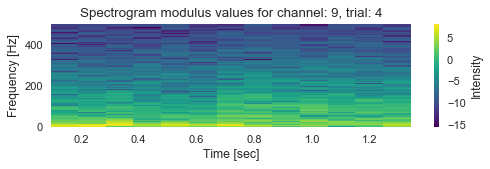

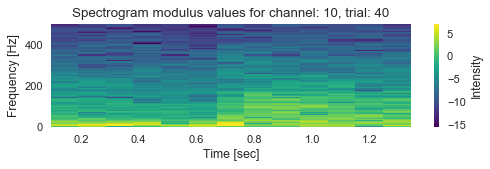

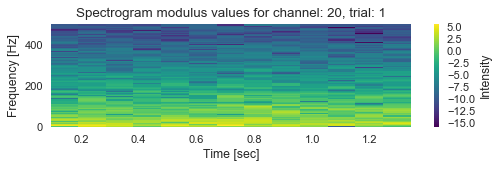

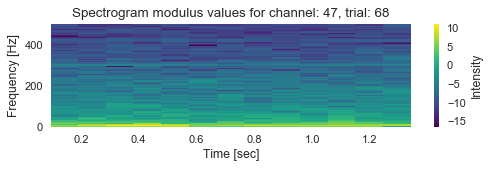

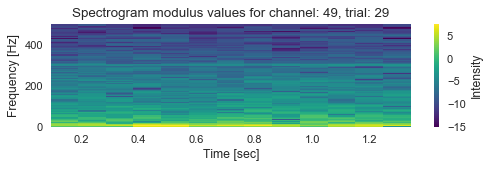

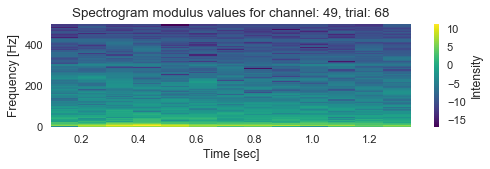

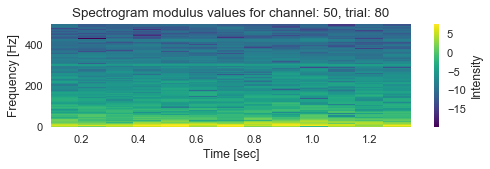

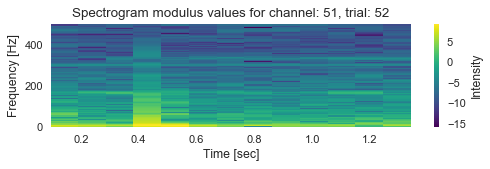

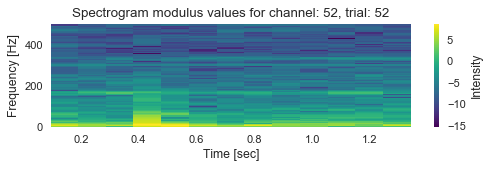

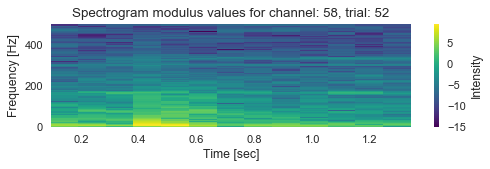

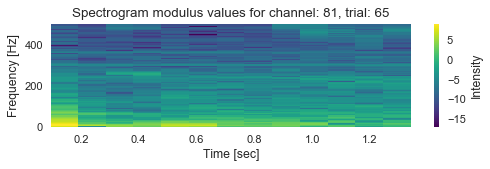

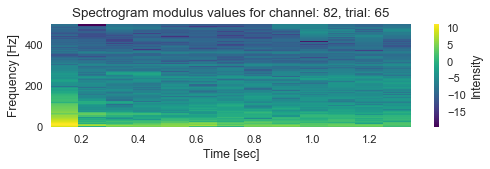

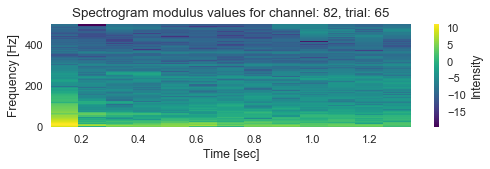

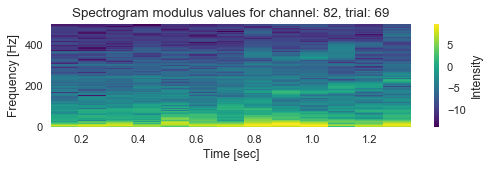

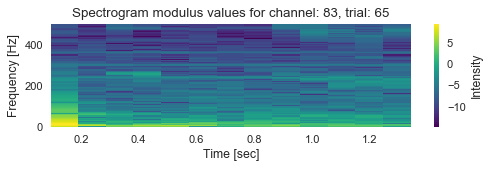

In [12]:
outlier_specgram_wrapper(a=H, k=3, max=True, f=f, t=t, all_pat_chn_trials=all_pat_chn_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, log_Sxx=True)

sorted_row_idx: [[25804 90265 18336]
 [29229 11571 14980]
 [99959 82993 82991]
 [99959 36275 54025]
 [    0 69957 91251]
 [84435 29002 49210]
 [90797 91012 11688]
 [12854 62352 37127]]
top_vals: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


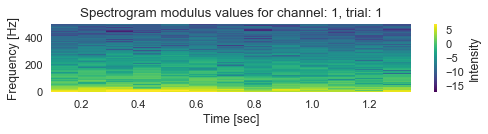

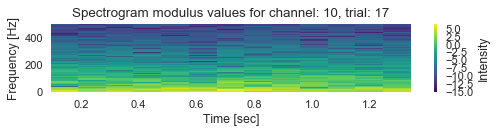

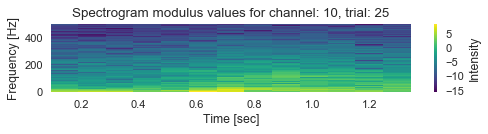

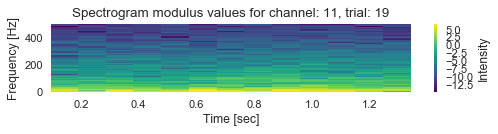

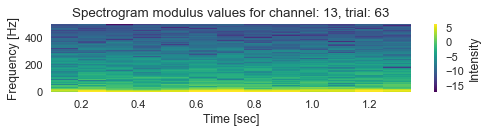

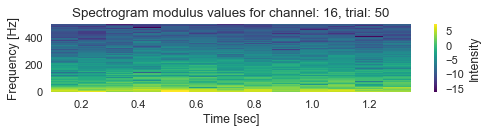

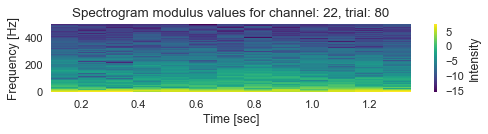

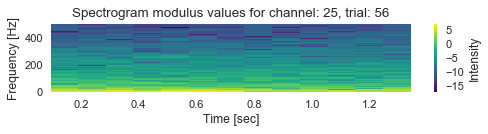

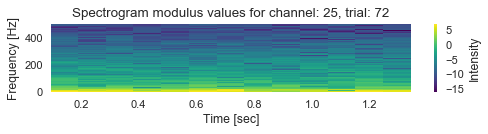

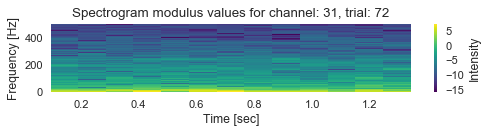

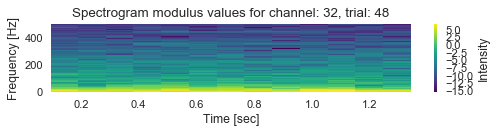

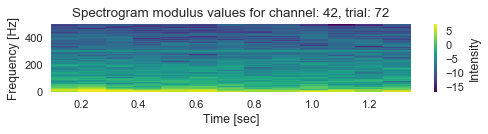

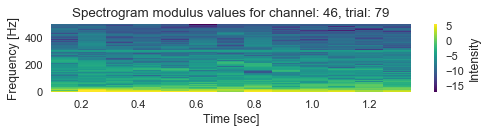

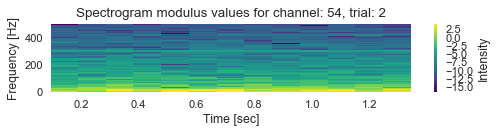

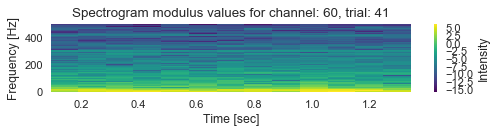

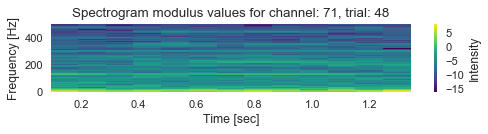

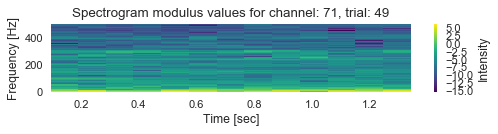

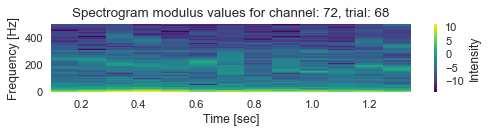

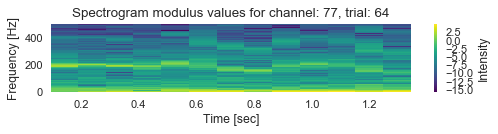

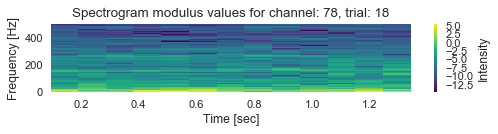

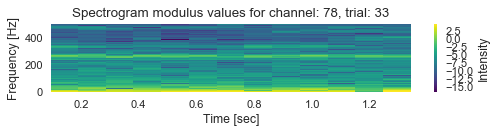

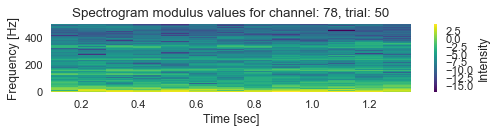

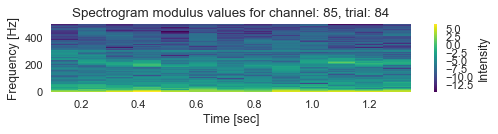

In [13]:
outlier_specgram_wrapper(a=H, k=3, max=False, f=f, t=t, all_pat_chn_trials=all_pat_chn_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, log_Sxx=True)

In [ ]:
outlier_idx = np.array([0, 12854, 25804, 29229, 84435, 90797, 99959])
outlier_loc = outlier_idx + 1
outlier_loc
channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
channel_idx = channel_num - 1
print(f"outlier_loc: {outlier_loc}")
print(f"channel_num: {channel_num}")
print(f"channel_idx: {channel_idx}")
trial_num = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3])[1] for comb in list(zip(channel_num, channel_idx, outlier_loc, [specgram_width]*len(channel_num)))]
trial_idx = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3])[0] for comb in list(zip(channel_num, channel_idx, outlier_loc, [specgram_width]*len(channel_num)))]
print(trial_num)
print(trial_idx)

In [ ]:
[specgram_width]

In [ ]:
list(zip(channel_num, channel_idx, outlier_loc, [specgram_width]*len(channel_num)))

In [ ]:
outlier_specgram_wrapper(a=H, k=3, max=False, f=f, t=t, all_pat_chn_trials=all_pat_chn_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, log_Sxx=True)

In [ ]:
a=H
k=1
max=False
f=f
t=t
all_pat_chn_trials=all_pat_chn_trials
fs=fs
window=window
nperseg=nperseg
noverlap=noverlap
log_Sxx=True

In [ ]:
sorted_row_idx, top_vals = get_topk_vals_and_idx_byrow(a=a, k=k, max=max)
print(f"sorted_row_idx: {sorted_row_idx}")
print(f"top_vals: {top_vals}")

In [ ]:
## Get the unique indices across all $H$ components
all_outlier_idx = sorted_row_idx.flatten(order='C')
all_outlier_idx_unq = np.unique(all_outlier_idx)
all_outlier_idx_unq

In [ ]:
len(t)

In [ ]:
np.array([0])

In [ ]:
trial_idx = get_outlier_indices(outlier_idx=np.array([100]), 
                                specgram_width=len(t), 
                                num_trials=all_pat_chn_trials[0].shape[0], 
                                num_channels=len(all_pat_chn_trials),
                                ret_type = "trial_idx")

In [ ]:
# Get the channels corresponding to the outlier indices
channel_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                  specgram_width=len(t), 
                                  num_trials=all_pat_chn_trials[0].shape[0], 
                                  num_channels=len(all_pat_chn_trials),
                                  ret_type = "channel_idx")
print("channel_idx:\n", channel_idx)

In [ ]:
outlier_idx = all_outlier_idx_unq
specgram_width=len(t)
num_trials=all_pat_chn_trials[0].shape[0]
num_channels=len(all_pat_chn_trials)

In [ ]:
outlier_idx = 1175
outlier_loc = outlier_idx + 1
channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
channel_idx = channel_num - 1
print(channel_num)
print(channel_idx)

In [ ]:
82/83

In [ ]:
outlier_idx = 1175
outlier_loc = outlier_idx + 1
channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
channel_idx = channel_num - 1
if channel_idx == 0 and outlier_loc == 0:
    trial_num = 1
    trial_idx = 0
elif channel_idx == 0 and outlier_loc > 0:
    trial_num = np.ceil(outlier_loc/(specgram_width))
    trial_idx = trial_num - 1
print(channel_num)
print(channel_idx)
print(trial_num)
print(trial_idx)

In [ ]:
trial_num = np.ceil((outlier_loc % (channel_idx * num_trials))/specgram_width)
trial_idx = trial_num - 1

In [ ]:
if ret_type == "channel_num":
    out = [int(chn) for chn in channel_num]
elif ret_type == "channel_idx":
    out = [int(chn_idx) for chn_idx in channel_idx]
elif ret_type == "trial_num":
    out = [int(trl) for trl in trial_num]
elif ret_type == "trial_idx":
    out = [int(trl_idx) for trl_idx in trial_idx]
else:
    None

return out

In [ ]:
# Get the channels corresponding to the outlier indices
trial_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                  specgram_width=len(t), 
                                  num_trials=all_pat_chn_trials[0].shape[0], 
                                  num_channels=len(all_pat_chn_trials),
                                  ret_type = "trial_idx")

In [ ]:


#print("channel_idx:\n", channel_idx) 
#print("trial_idx:\n", trial_idx)

# Create list of (channel, index) tuples for the outliers
out_chn_trl = list(zip(channel_idx, trial_idx))
#print(f"out_chn_trl: {out_chn_trl}")

# Get the corresponding trials for the outlier indices
out_trials = [all_pat_chn_trials[x[0]][x[1]] for x in out_chn_trl]
out_trials_v = np.vstack(out_trials)
#print(f"out_trials_v.shape: {out_trials_v.shape}")    

# Generate the spectrograms for the outlier trials
specgrams = [erp_gen_spectrogram(x = trials, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx = log_Sxx)[2] 
             for trials in out_trials_v]
#print(specgrams[0].shape)

plot_specgrams(specgrams=specgrams, f=f, t=t, out_chn_trl=out_chn_trl)